Importing all necessary packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import activations
#from keras.optimizers import gradient_descent_v2
#from google.colab import drive
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as pyplot
import numpy as np
import pandas as pd
import seaborn as sns

Mounting Google Drive for dataset

In [ ]:
# Mount Google Drive
drive.mount('/gdrive', force_remount=True)
# Location of Zip File
drive_path = '/gdrive/MyDrive/Dataset.zip'
local_path = '/content'
!cp '{drive_path}' .
os.chdir(local_path)
!unzip -q 'Dataset.zip'

Mounted at /gdrive


Splitting Dataset into Train and Test datasets



In [ ]:
data = []
labels = []
img_height = 200
img_width = 200
import glob
rd = glob.glob('Preprocess/RD/*.*')
non_rd = glob.glob('Preprocess/Non RD/*.*')

for i in rd:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (img_height,img_width))
    image=np.array(image)
    data.append(image)
    labels.append(0)

for i in non_rd:
    image=tf.keras.preprocessing.image.load_img(i, color_mode='rgb',
    target_size= (img_height,img_width))
    image=np.array(image)
    data.append(image)
    labels.append(1)

data = np.array(data)
labels = np.array(labels)

from sklearn.model_selection import train_test_split
trainX, testX, trainy, testy = train_test_split(data, labels, test_size=0.2,
                                                random_state=42)

Normalizing Input

In [ ]:
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

Function to plot accuracy curve for each training

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

# Fit the data augmentation on training data
datagen.fit(trainX)

In [ ]:
def plot_accuracy(history, miny=None):
  pyplot.plot(history.history['acc'])
  pyplot.plot(history.history['val_acc'])
  pyplot.title('model accuracy')
  pyplot.ylabel('accuracy')
  pyplot.xlabel('epoch')
  pyplot.legend(['train', 'val'], loc='upper left')
  pyplot.show()

Function to plot confusion matrix for each training

In [ ]:
def plot_conf(model, testX, testy):
  y_pred = model.predict(testX)
  pred=np.argmax(y_pred, axis=1)
  con_mat = tf.math.confusion_matrix(labels=testy, predictions=pred).numpy()
  con_mat_norm = np.around(con_mat.astype('float') / con_mat.sum(axis=1)[:, np.newaxis], decimals=2)
  classes = ["RD", "Non-RD"]
  con_mat_df = pd.DataFrame(con_mat_norm, index = classes, columns = classes)
  figure = pyplot.figure(figsize=(4, 4))
  sns.heatmap(con_mat_df, annot=True,cmap=pyplot.cm.Blues)
  pyplot.tight_layout()
  pyplot.ylabel('True label')
  pyplot.xlabel('Predicted label')
  pyplot.show()

Function to plot layerwise accuracy and loss plots

In [ ]:
def layer_plot(scores_acc, scores_loss):
  keys = list(scores_acc.keys())
  pyplot.plot(keys, [scores_acc[k][0] for k in keys], label = 'train', marker = '.')
  pyplot.plot(keys, [scores_acc[k][1] for k in keys], label = 'test', marker = '.')
  pyplot.legend()
  pyplot.ylabel('Accuracy')
  pyplot.xlabel('Number of Layers')
  pyplot.show()
  keys = list(scores_loss.keys())
  pyplot.plot(keys, [scores_loss[k][0] for k in keys], label = 'train', marker = '.')
  pyplot.plot(keys, [scores_loss[k][1] for k in keys], label = 'test', marker = '.')
  pyplot.legend()
  pyplot.ylabel('Loss')
  pyplot.xlabel('Number of Layers')
  pyplot.show()

Function to train and evaluate models prepared

In [ ]:
def evaluate_model(model, trainX, trainy, testX, testy):
  train_loss, train_acc = model.evaluate(trainX, trainy, verbose=1)
  test_loss, test_acc = model.evaluate(testX, testy, verbose=1)
  print("Train Loss = %.3f Train Acc = %.3f Test Loss=%.3f' Test Acc = %.3f " % (train_loss, train_acc, test_loss, test_acc))
  scores_acc[len(model.layers)] = (train_acc, test_acc)
  scores_loss[len(model.layers)] = (train_loss, test_loss)

In [ ]:
from tensorflow.keras.optimizers import Adam

Base Model


C:\Users\BIOMIL\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 194, 194, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 194, 194, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 194, 194, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 97, 97, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 602176)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 50)                  │      30,108,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 30,118,680 (114.89 MB)

 Trainable params: 30,118,552 (114.89 MB)

 Non-trainable params: 128 (512.00 B)

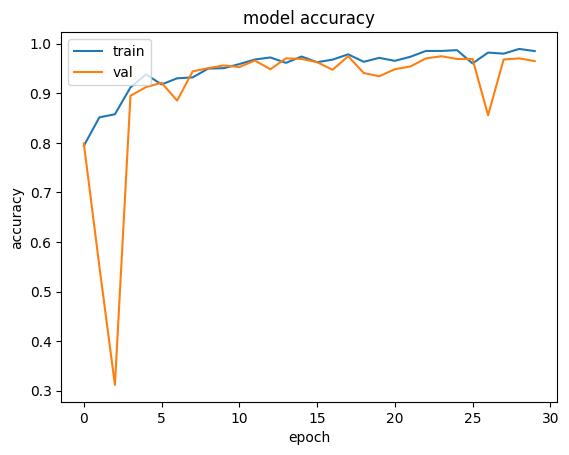

115/115 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step - acc: 0.9918 - loss: 0.0260
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - acc: 0.9574 - loss: 0.1795
Train Loss = 0.026 Train Acc = 0.992 Test Loss=0.150' Test Acc = 0.965 
29/29 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step


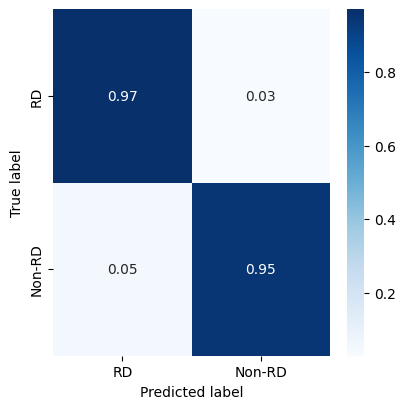

Base Model +1


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 194, 194, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 194, 194, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 194, 194, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 97, 97, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 93, 93, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 93, 93, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 93, 93, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 135424)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │       6,771,250 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,883,800 (26.26 MB)

 Trainable params: 6,873,944 (26.22 MB)

 Non-trainable params: 9,856 (38.50 KB)

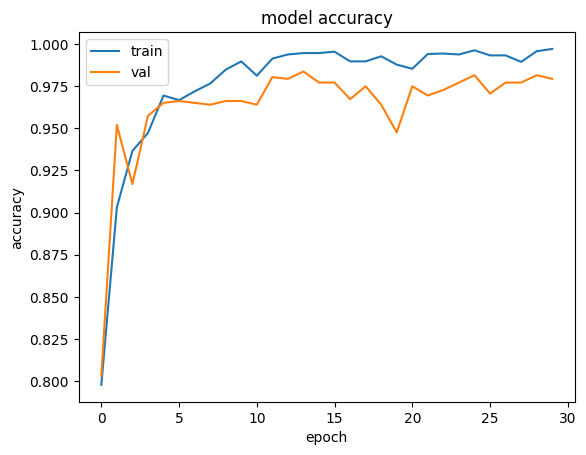

115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 112ms/step - acc: 0.9963 - loss: 0.0086
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 112ms/step - acc: 0.9720 - loss: 0.1714
Train Loss = 0.006 Train Acc = 0.997 Test Loss=0.121' Test Acc = 0.979 
29/29 ━━━━━━━━━━━━━━━━━━━━ 3s 109ms/step


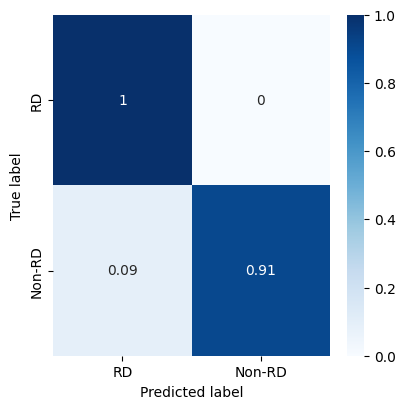

Base Model +2


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 194, 194, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 194, 194, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 194, 194, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 97, 97, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 93, 93, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 93, 93, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 93, 93, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 44, 44, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 44, 44, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 61952)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 50)                  │       3,097,650 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,284,568 (12.53 MB)

 Trainable params: 3,171,864 (12.10 MB)

 Non-trainable params: 112,704 (440.25 KB)

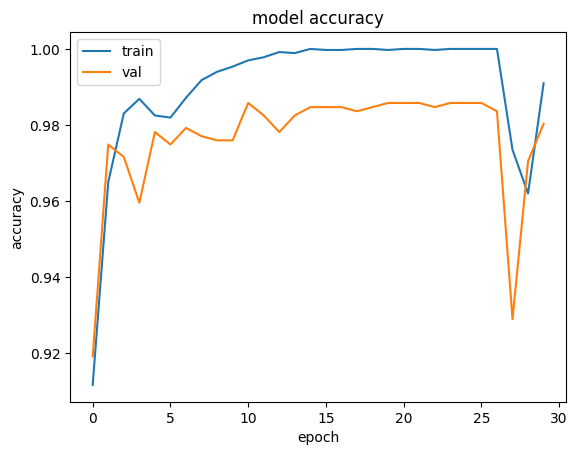

115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - acc: 0.9928 - loss: 0.0202
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 122ms/step - acc: 0.9772 - loss: 0.1069
Train Loss = 0.022 Train Acc = 0.994 Test Loss=0.092' Test Acc = 0.980 
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 124ms/step


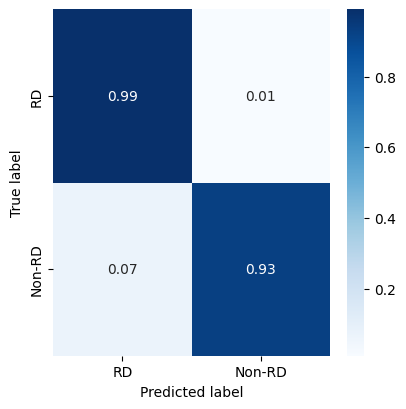

Base Model +3


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 194, 194, 64)        │           9,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 194, 194, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 194, 194, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 97, 97, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 93, 93, 64)          │         102,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 93, 93, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 93, 93, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 46, 46, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 44, 44, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 44, 44, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 44, 44, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 22, 22, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 21, 21, 256)         │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 21, 21, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 21, 21, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 50)                  │       1,280,050 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             102 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 1,599,320 (6.10 MB)

 Trainable params: 1,411,992 (5.39 MB)

 Non-trainable params: 187,328 (731.75 KB)

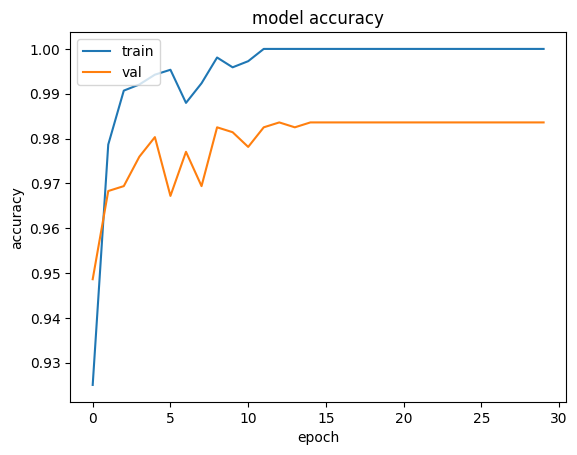

115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - acc: 1.0000 - loss: 1.5739e-05
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - acc: 0.9847 - loss: 0.0917
Train Loss = 0.000 Train Acc = 1.000 Test Loss=0.073' Test Acc = 0.984 
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step


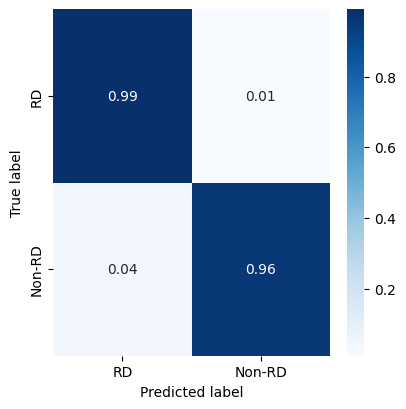

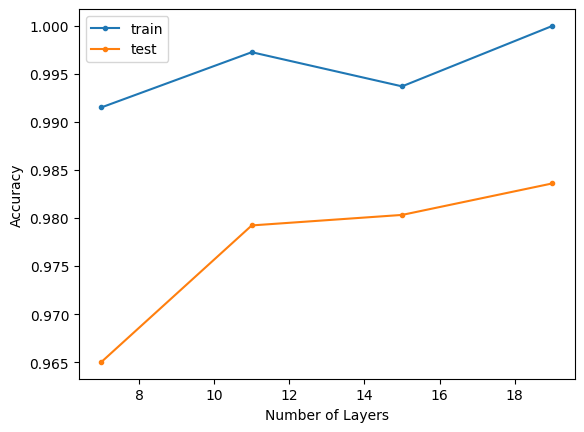

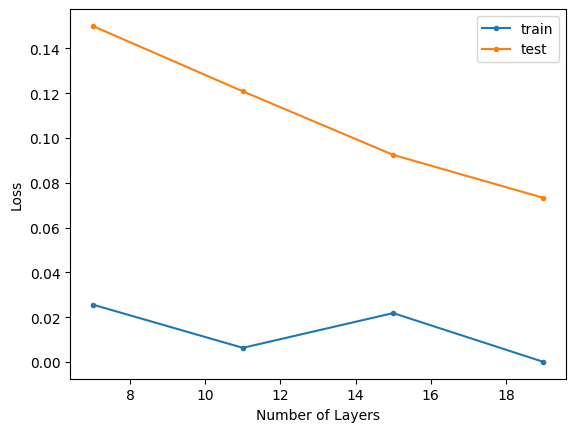

In [ ]:
print("Base Model")
scores_acc = dict()
scores_loss = dict()
n_epochs = 30

model = models.Sequential()
model.add(layers.Conv2D(64, 7, input_shape=(img_height,img_width,3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(2, activation="softmax"))
#model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.00021, momentum=0.9), metrics=['acc'])
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
model.summary()

#history = model.fit(datagen.flow(trainX, trainy, batch_size=32), validation_data=(testX,testy), epochs=n_epochs, verbose=0)
history = model.fit(trainX, trainy, validation_data=(testX,testy), epochs=n_epochs, verbose=0, batch_size = 32)
plot_accuracy(history)
evaluate_model(model,trainX,trainy,testX,testy)
plot_conf(model,testX,testy)


print("Base Model +1")
#remove the output Layer
model.pop()
model.pop()
model.pop();
#mark all remaining Layers as non-trainable
for layer in model.layers:
  layer.trainable = False

model.add(layers.Conv2D(64, 5, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(2, activation="softmax"))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.00021, momentum=0.9), metrics=['acc'])
model.summary()

#history = model.fit(datagen.flow(trainX, trainy, batch_size=32), validation_data=(testX,testy), epochs=n_epochs, verbose=0)
history = model.fit(trainX, trainy, validation_data=(testX,testy), epochs=n_epochs, verbose=0, batch_size = 32)
plot_accuracy(history)
evaluate_model(model,trainX,trainy,testX,testy)
plot_conf(model,testX,testy)


print("Base Model +2")
#remove the output Layer
model.pop()
model.pop()
model.pop();
#mark all remaining Layers as non-trainable
for layer in model.layers:
  layer.trainable = False
model.add(layers.Conv2D(128, 3, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(2, activation="softmax"))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.00021, momentum=0.9), metrics=['acc'])
model.summary()

#history = model.fit(datagen.flow(trainX, trainy, batch_size=32), validation_data=(testX,testy), epochs=n_epochs, verbose=0)
history = model.fit(trainX, trainy, validation_data=(testX,testy), epochs=n_epochs, verbose=0, batch_size = 32)
plot_accuracy(history)
evaluate_model(model,trainX,trainy,testX,testy)
plot_conf(model,testX,testy)


print("Base Model +3")
#remove the output Layer
model.pop()
model.pop()
model.pop()
#mark all remaining Layers as non-trainable
for layer in model.layers:
  layer.trainable = False
model.add(layers.Conv2D(256, 2, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Activation(activations.relu))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(50, activation='relu', kernel_initializer='he_uniform'))
model.add(layers.Dense(2, activation="softmax"))
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['acc'])
#model.compile(loss='sparse_categorical_crossentropy', optimizer=SGD(learning_rate=0.000021, momentum=0.9), metrics=['acc'])
model.summary()

#history = model.fit(datagen.flow(trainX, trainy, batch_size=32), validation_data=(testX,testy), epochs=n_epochs, verbose=0)
history = model.fit(trainX, trainy, validation_data=(testX,testy), epochs=n_epochs, verbose=0, batch_size = 32)
plot_accuracy(history)
evaluate_model(model,trainX,trainy,testX,testy)
plot_conf(model,testX,testy)


# final plotting of layer wise data
layer_plot(scores_acc, scores_loss)

In [ ]:
from keras.optimizers import SGD

In [ ]:
from sklearn import metrics
# Creating the confusion matrix
y_pred = model.predict(testX)
pred=np.argmax(y_pred, axis=1)
cm = metrics.confusion_matrix(testy, pred)
accuracy = metrics.accuracy_score(testy, pred)
accuracy

29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step


0.9836065573770492

In [ ]:
recall_sensitivity = metrics.recall_score(testy, pred, pos_label=1)
recall_specificity = metrics.recall_score(testy, pred, pos_label=0)
recall_specificity,recall_sensitivity

115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step
115/115 ━━━━━━━━━━━━━━━━━━━━ 14s 122ms/step
29/29 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step


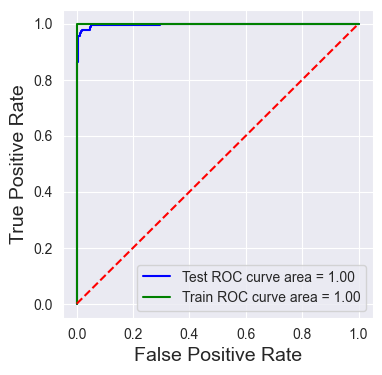

In [ ]:
from matplotlib import pyplot as plt

sns.set_style('darkgrid')
preds_train = model.predict(trainX)
# calculate prediction probability
prob_train = np.squeeze(model.predict(trainX)[:,1].reshape(1,-1))
prob_test = np.squeeze(model.predict(testX)[:,1].reshape(1,-1)) # false positive rate, true positive rate, thresholds
fpr1, tpr1, thresholds1 = metrics.roc_curve(testy, prob_test)
fpr2, tpr2, thresholds2 = metrics.roc_curve(trainy, prob_train) # auc score
auc1 = metrics.auc(fpr1, tpr1)
auc2 = metrics.auc(fpr2, tpr2)
plt.figure(figsize=(4,4))
# plot auc
plt.plot(fpr1, tpr1, color='blue', label='Test ROC curve area = %0.2f'%auc1)
plt.plot(fpr2, tpr2, color='green', label='Train ROC curve area = %0.2f'%auc2)
plt.plot([0,1],[0,1], 'r--')
#plt.xlim([-0.1, 1.1])
#plt.ylim([-0.1, 1.1])
plt.xlabel('False Positive Rate', size=14)
plt.ylabel('True Positive Rate', size=14)
plt.legend(loc='lower right')
plt.show()